# Recommender Systems 2018/19

### Practice 9 - Collaborative Boosted FW


### Underlying idea... the way to capture the feature importance from the user point of view, is to... use its point of view (e.g., ratings, collaborative similarity)

## A few info about feature weightign techniques

* Information retrieval methods (TF-IDF, BM25..) do not optimize a predictive model
* Embedding methods (FISM, UFSM, Factorization Machines) optimize everything at the same time, model and weights, but are difficult to train and sensitive to noise
* Wrapper methods (LFW, CFW) apply a two step approach approximating an already built collaborative model, more robust and easier to tune


In [1]:
from urllib.request import urlretrieve
import zipfile, os

# If file exists, skip the download
data_file_path = "data/Movielens_10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)

dataFile = zipfile.ZipFile(data_file_name)
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path="data/Movielens_10M")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)

import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()



In [2]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)

userList_unique = list(set(userList_icm))
itemList_unique = list(set(itemList_icm))
tagList_unique = list(set(tagList_icm))

numUsers = len(userList_unique)
numItems = len(itemList_unique)
numTags = len(tagList_unique)


print ("Number of items\t {}, Number of users\t {}".format(numItems, numUsers))
print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

import numpy as np

ones = np.ones(len(tagList_icm))

ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape=(URM_all.shape[1], tagList_icm.max()+1))
ICM_all = ICM_all.tocsr()

Number of items	 7601, Number of users	 4009
Number of tags	 16529, Number of item-tag tuples 95580

Data example:
[15, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[4973, 1747, 1747, 2424, 2424, 2424, 2947, 2947, 3033, 3033]
['excellent!', 'politics', 'satire', 'chick flick 212', 'hanks', 'ryan', 'action', 'bond', 'spoof', 'star wars']


In [3]:

from Notebooks_utils.data_splitter import train_test_holdout

URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)
URM_train, URM_validation = train_test_holdout(URM_train, train_perc = 0.9)

### To shorten the notebook let's use the parameters we computed the previous time (Warning: not very clean, the data split may be different, also, running BayesianSearch multiple times may result in a different solution)

In [4]:
best_params_ItemKNNCF = {'topK': 700, 'shrink': 200, 'similarity': 'cosine', 'normalize': True}
best_params_ItemKNNCBF = {'topK': 500, 'shrink': 1000, 'similarity': 'cosine', 'normalize': True}

### Step 1: Create the two models, collaborative and content based

In [5]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender


itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(**best_params_ItemKNNCF)

itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
itemKNNCBF.fit(**best_params_ItemKNNCBF)

ItemKNNCFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCFRecommender: URM Detected 54497 (83.67 %) cold items.
Similarity column 58940 ( 90 % ), 1964.12 column/sec, elapsed time 0.50 min
Similarity column 65134 ( 100 % ), 2005.26 column/sec, elapsed time 0.54 min
ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54497 (83.67 %) cold items.
Similarity column 65134 ( 100 % ), 4160.16 column/sec, elapsed time 0.26 min


### Question, how the two similarities differ?

In [6]:
W_sparse_CF = itemKNNCF.W_sparse
W_sparse_CBF = itemKNNCBF.W_sparse

## Let's plt the global similarity distribution 

In [7]:
W_sparse_CF_sorted = np.sort(W_sparse_CF.data.copy())
W_sparse_CBF_sorted = np.sort(W_sparse_CBF.data.copy())

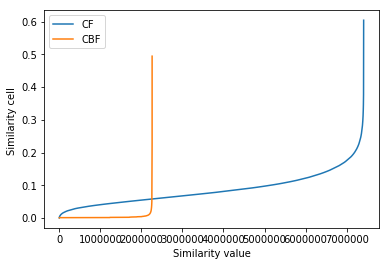

In [35]:
import numpy as np
import matplotlib.pyplot as pyplot


pyplot.plot(W_sparse_CF_sorted, label = 'CF')
pyplot.plot(W_sparse_CBF_sorted, label = 'CBF')
pyplot.ylabel('Similarity cell ')
pyplot.xlabel('Similarity value')
pyplot.legend()
pyplot.show()

## Let's now plot the delta for the common values

In [9]:
# Get common structure
W_sparse_CF_structure = W_sparse_CF.copy()
W_sparse_CF_structure.data = np.ones_like(W_sparse_CF_structure.data)

W_sparse_CBF_structure = W_sparse_CBF.copy()
W_sparse_CBF_structure.data = np.ones_like(W_sparse_CBF_structure.data)

W_sparse_common = W_sparse_CF_structure.multiply(W_sparse_CBF_structure)

# Get values of both in common structure of CF
W_sparse_delta = W_sparse_CBF.copy().multiply(W_sparse_common)
W_sparse_delta -= W_sparse_CF.copy().multiply(W_sparse_common)

In [10]:
W_sparse_delta_sorted = np.sort(W_sparse_delta.data.copy())

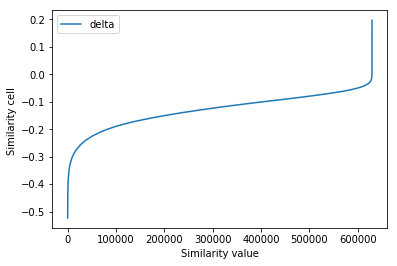

In [11]:
pyplot.plot(W_sparse_delta_sorted, label = 'delta')
pyplot.ylabel('Similarity cell ')
pyplot.xlabel('Similarity value')
pyplot.legend()
pyplot.show()

In [12]:
# How many values we have in common?

print("W_sparse_CF has {:.2E} values and {:.2f} % in common with CBF".format(W_sparse_CF.nnz, W_sparse_common.nnz/W_sparse_CF.nnz*100))
print("W_sparse_CBF has {:.2E} values and {:.2f} % in common with CF".format(W_sparse_CBF.nnz, W_sparse_common.nnz/W_sparse_CBF.nnz*100))

print("W_sparse_delta has {:.2E} values".format(W_sparse_delta.nnz))


W_sparse_CF has 7.41E+06 values and 8.49 % in common with CBF
W_sparse_CBF has 2.26E+06 values and 27.84 % in common with CF
W_sparse_delta has 6.29E+05 values


## What do we see?
## The great majority of similarities are not common... the models are modeling two very different phenomena

# Idea: 

## what if we were to weight features in such a way to approximate as well as possible the collaborative similarity?

### Basic model:  $S_{CBF} = ICM \cdot diag(feature\_weights) \cdot ICM^{T}$ 


### We want  $S_{CBF} = S_{CF}$

### Hence we wish to find the weights such that  $S_{CF} = ICM \cdot diag(feature\_weights) \cdot ICM^{T}$ 

### Now, we can rearrange the equations considering that we need only weights for features the two items have in common... this becomes a regression problem in form Ax = b. In our case A are the common features, x the weights and b the collaborative similarity


### Since it is a regression problem, we can use an already available solver like linalg in scipy.sparse

### It takes as imput two data structures, one is sparse and the other is the target value

In [13]:
W_sparse_delta = W_sparse_delta.tocoo()


item_index_1 = W_sparse_delta.row[666]
item_index_2 = W_sparse_delta.col[666]

In [14]:
print("Item indices are {} and {}".format(item_index_1, item_index_2))

Item indices are 2 and 4571


In [15]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

Collaborative similarity value is 0.17570984363555908
Content-based similarity value is 0.022447967901825905


### Compute the common features

In [16]:
common_features = ICM_all[item_index_1,:].multiply(ICM_all[item_index_2,:])
common_features

<1x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [17]:
common_features.indices

array([15465], dtype=int32)

## These items have just a common feature, that is a common scenario

### Let's look for items having  a few features in common, say 5

In [18]:
min_common_features = 5

for inner_index in range(len(W_sparse_delta.row)):

    item_index_1 = W_sparse_delta.row[inner_index]
    item_index_2 = W_sparse_delta.col[inner_index]

    common_features = ICM_all[item_index_1,:].multiply(ICM_all[item_index_2,:])
    
    if common_features.nnz >= min_common_features:
        
        # Bad programming, don't do this at home
        break
        
        

print("Item indices are {} and {}".format(item_index_1, item_index_2))

print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))
    
common_features.indices

Item indices are 1 and 50
Collaborative similarity value is 0.32827049493789673
Content-based similarity value is 0.003887253813445568


array([ 6688,  9727, 10262, 11154, 15951, 16099], dtype=int32)

In [19]:
from scipy.sparse import linalg

loss_tolerance = 1e-6
iteration_limit = 50000
damp_coeff=0.0

W_sparse_CF_value = W_sparse_CF[item_index_1, item_index_2]

In [20]:
linalg_result = linalg.lsqr(common_features, W_sparse_CF_value, show = False, atol=loss_tolerance, btol=loss_tolerance,
                  iter_lim = iteration_limit, damp=damp_coeff)

In [21]:
feature_weights = linalg_result[0].copy()
feature_weights

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
feature_weights[common_features.indices]

array([0.0364745, 0.0364745, 0.0364745, 0.072949 , 0.0364745, 0.0364745])

### Note that all weights will be zeros except for the features those items have in common, nothing can be learned if a feature is not common

### If a dataset has a very sparse ICM, this FW method will struggle

In [23]:
new_CBF_value = common_features.dot(feature_weights)
new_CBF_value

array([0.32827049])

In [24]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

print("Weighted Content-based similarity value is {}".format(new_CBF_value[0]))

Collaborative similarity value is 0.32827049493789673
Content-based similarity value is 0.003887253813445568
Weighted Content-based similarity value is 0.32827049493789673


### Note that we learned the CF similarity amost exactly...

### Warning: 5 common features and 1 similarity value, more parameters than data points, overfitting!

### if we want to apply this method to the whole dataset we have to compute the common features of all items having a common similarity value. Whe already know who they are, thanks to W_sparse_delta

In [25]:
from FeatureWeighting.CFW_D_Similarity_Linalg import CFW_D_Similarity_Linalg

In [26]:
CFW_weithing = CFW_D_Similarity_Linalg(URM_train, ICM_all, W_sparse_CF)
CFW_weithing.fit()

CFW_D_Similarity_Linalg: URM Detected 1690 (2.36 %) cold users.
CFW_D_Similarity_Linalg: URM Detected 54497 (83.67 %) cold items.
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 8197.86 column/sec, elapsed time 0.13 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.75E-03, nonzero cells 7414519
CFW_D_Similarity_Linalg: Content S density: 3.72E-04, nonzero cells 1576400
CFW_D_Similarity_Linalg: Content S structure has 494341 out of 1576400 ( 31.36%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 6.73E+04, average is: 1.36E-01, average over all collaborative data is 8.66E-02
Similarity column 65134 ( 100 % ), 8606.05 column/sec, elapsed time 0.13 min


In [27]:
from Base.Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[5])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[5])


In [28]:
results_dict, _ = evaluator_test.evaluateRecommender(itemKNNCF)
results_dict

EvaluatorHoldout: Processed 21001 ( 30.09% ) in 30.93 sec. Users per second: 679
EvaluatorHoldout: Processed 42713 ( 61.19% ) in 1.02 min. Users per second: 701
EvaluatorHoldout: Processed 64001 ( 91.69% ) in 1.53 min. Users per second: 699
EvaluatorHoldout: Processed 69799 ( 100.00% ) in 1.64 min. Users per second: 708


{5: {'ROC_AUC': 0.4364365296541968,
  'PRECISION': 0.3118468745971436,
  'PRECISION_RECALL_MIN_DEN': 0.31874167251687435,
  'RECALL': 0.10426780711327836,
  'MAP': 0.2346349199527389,
  'MRR': 0.5186292067221493,
  'NDCG': 0.15243248464962666,
  'F1': 0.15628186746845701,
  'HIT_RATE': 1.5592343729852862,
  'ARHR': 0.775873818631559,
  'RMSE': 41.76490220136474,
  'NOVELTY': 0.000701773758518289,
  'AVERAGE_POPULARITY': 0.5563869474548924,
  'DIVERSITY_MEAN_INTER_LIST': 0.9302546128224348,
  'DIVERSITY_HERFINDAHL': 0.9860482570403023,
  'COVERAGE_ITEM': 0.021678386096355206,
  'COVERAGE_USER': 0.9752822490498547,
  'DIVERSITY_GINI': 0.07248708192902546,
  'SHANNON_ENTROPY': 6.95882362718298}}

In [29]:
results_dict, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
results_dict

EvaluatorHoldout: Processed 23001 ( 32.95% ) in 30.58 sec. Users per second: 752
EvaluatorHoldout: Processed 47001 ( 67.34% ) in 1.01 min. Users per second: 772
EvaluatorHoldout: Processed 69799 ( 100.00% ) in 1.48 min. Users per second: 784


{5: {'ROC_AUC': 0.2759889110159181,
  'PRECISION': 0.1537385922434477,
  'PRECISION_RECALL_MIN_DEN': 0.15496568718750192,
  'RECALL': 0.033535595871933874,
  'MAP': 0.10987751734743201,
  'MRR': 0.3027469352474093,
  'NDCG': 0.06722872449586406,
  'F1': 0.05506060767135511,
  'HIT_RATE': 0.7686929612172094,
  'ARHR': 0.4050062799371437,
  'RMSE': 3.1688100420163057,
  'NOVELTY': 0.0007259748546601234,
  'AVERAGE_POPULARITY': 0.4789066571502367,
  'DIVERSITY_MEAN_INTER_LIST': 0.8752132395263442,
  'DIVERSITY_HERFINDAHL': 0.975040140095015,
  'COVERAGE_ITEM': 0.007308011176958271,
  'COVERAGE_USER': 0.9752822490498547,
  'DIVERSITY_GINI': 0.10143994482149296,
  'SHANNON_ENTROPY': 5.956345692561511}}

In [30]:
results_dict, _ = evaluator_test.evaluateRecommender(CFW_weithing)
results_dict

EvaluatorHoldout: Processed 24001 ( 34.39% ) in 30.83 sec. Users per second: 779
EvaluatorHoldout: Processed 48001 ( 68.77% ) in 1.02 min. Users per second: 788
EvaluatorHoldout: Processed 69799 ( 100.00% ) in 1.45 min. Users per second: 803


{5: {'ROC_AUC': 0.24912725588236662,
  'PRECISION': 0.14954655510824125,
  'PRECISION_RECALL_MIN_DEN': 0.15079251374184224,
  'RECALL': 0.03237966746280794,
  'MAP': 0.10105408227752578,
  'MRR': 0.2758869515800296,
  'NDCG': 0.06295531728362827,
  'F1': 0.05323331245139487,
  'HIT_RATE': 0.7477327755411969,
  'ARHR': 0.3704432250700819,
  'RMSE': 14.969350323440331,
  'NOVELTY': 0.0007009003532984399,
  'AVERAGE_POPULARITY': 0.562098139201455,
  'DIVERSITY_MEAN_INTER_LIST': 0.7353008665222058,
  'DIVERSITY_HERFINDAHL': 0.9470580663949825,
  'COVERAGE_ITEM': 0.010163662603248688,
  'COVERAGE_USER': 0.9752822490498547,
  'DIVERSITY_GINI': 0.04455624431774436,
  'SHANNON_ENTROPY': 5.051112498039045}}

### This algorithm has parameters too:
* topK, the usual number of neighbors
* add_zeros_quota, the percentage of zero collaborative similarities to add to the train set, this helps the regressor in finding non-relevant features
* normalize_similarity, apply or not the usual cosine denominator

In [31]:
from ParameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real, Integer, Categorical
from ParameterTuning.SearchAbstractClass import SearchInputRecommenderArgs


recommender_class = CFW_D_Similarity_Linalg

parameterSearch = SearchBayesianSkopt(recommender_class,
                                 evaluator_validation=evaluator_validation,
                                 evaluator_test=evaluator_test)


hyperparameters_range_dictionary = {}
hyperparameters_range_dictionary["topK"] = Integer(5, 1000)
hyperparameters_range_dictionary["add_zeros_quota"] = Real(low = 0, high = 1, prior = 'uniform')
hyperparameters_range_dictionary["normalize_similarity"] = Categorical([True, False])


recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train, ICM_all, W_sparse_CF],
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {}
)


output_folder_path = "result_experiments/"

import os

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

n_cases = 10
metric_to_optimize = "MAP"


# Clone data structure to perform the fitting with the best hyperparameters on train + validation data
recommender_input_args_last_test = recommender_input_args.copy()
recommender_input_args_last_test.CONSTRUCTOR_POSITIONAL_ARGS[0] = URM_train + URM_validation


parameterSearch.search(recommender_input_args,
                       recommender_input_args_last_test = recommender_input_args_last_test,
                       parameter_search_space = hyperparameters_range_dictionary,
                       n_cases = n_cases,
                       n_random_starts = int(n_cases/3),
                       save_model = "no",
                       output_folder_path = output_folder_path,
                       output_file_name_root = recommender_class.RECOMMENDER_NAME,
                       metric_to_optimize = metric_to_optimize
                      )


Iteration No: 1 started. Evaluating function at random point.
CFW_D_Similarity_Linalg: URM Detected 1690 (2.36 %) cold users.
CFW_D_Similarity_Linalg: URM Detected 54497 (83.67 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 369, 'add_zeros_quota': 0.004204312723170457, 'normalize_similarity': True}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 8501.85 column/sec, elapsed time 0.13 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.75E-03, nonzero cells 7414519
CFW_D_Similarity_Linalg: Content S density: 4.34E-04, nonzero cells 1842778
CFW_D_Similarity_Linalg: Content S structure has 561099 out of 1842778 ( 30.45%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 8.47E+06, average is: 1.51E+01, average over all collaborative data is 8.66E-02
Similarity column 65134 ( 100 % ), 4337.66 column/sec, elapsed time 0.25 min
EvaluatorHoldout: Processed 24001 ( 35.55% ) in 30.30 sec. Users per second: 7

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 381.7368
Function value obtained: -0.0346
Current minimum: -0.0346
Iteration No: 4 started. Searching for the next optimal point.
CFW_D_Similarity_Linalg: URM Detected 1690 (2.36 %) cold users.
CFW_D_Similarity_Linalg: URM Detected 54497 (83.67 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 6, 'add_zeros_quota': 0.9897195531431559, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 8472.06 column/sec, elapsed time 0.13 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.75E-03, nonzero cells 7414519
CFW_D_Similarity_Linalg: Content S density: 1.03E-05, nonzero cells 43861
CFW_D_Similarity_Linalg: Content S structure has 19863 out of 43861 ( 45.29%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 2.91E+03, average is: 1.46E-01, average over all collaborative data is 8.66E-02
Similarity column 65134 ( 1

EvaluatorHoldout: Processed 67517 ( 100.00% ) in 1.51 min. Users per second: 745
SearchBayesianSkopt: Config 6 is suboptimal. Config: {'topK': 1000, 'add_zeros_quota': 1.0, 'normalize_similarity': False} - results: ROC_AUC: 0.1239355, PRECISION: 0.0572034, PRECISION_RECALL_MIN_DEN: 0.0638145, RECALL: 0.0308181, MAP: 0.0355151, MRR: 0.1241473, NDCG: 0.0423599, F1: 0.0400562, HIT_RATE: 0.2860169, ARHR: 0.1409129, RMSE: 16.6968168, NOVELTY: 0.0006916, AVERAGE_POPULARITY: 0.5996897, DIVERSITY_MEAN_INTER_LIST: 0.6043739, DIVERSITY_HERFINDAHL: 0.9208730, COVERAGE_ITEM: 0.0058955, COVERAGE_USER: 0.9433965, DIVERSITY_GINI: 0.0419402, SHANNON_ENTROPY: 4.2559947, 

Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 501.2699
Function value obtained: -0.0355
Current minimum: -0.0395
Iteration No: 8 started. Searching for the next optimal point.
CFW_D_Similarity_Linalg: URM Detected 1690 (2.36 %) cold users.
CFW_D_Similarity_Linalg: URM Detected 54497 (83.67 %) cold item

C:\Users\ferra\Anaconda3\envs\RecSysFramework\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "



SearchBayesianSkopt: Testing config: {'topK': 1000, 'add_zeros_quota': 1.0, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 8559.06 column/sec, elapsed time 0.13 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.75E-03, nonzero cells 7414519
CFW_D_Similarity_Linalg: Content S density: 7.28E-04, nonzero cells 3087872
CFW_D_Similarity_Linalg: Generating train data. Sample 2383105 ( 154.35 %) 
CFW_D_Similarity_Linalg: Content S structure has 845325 out of 3087872 ( 27.38%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.17E+05, average is: 1.38E-01, average over all collaborative data is 8.66E-02
Similarity column 65134 ( 100 % ), 8852.53 column/sec, elapsed time 0.12 min
EvaluatorHoldout: Processed 22278 ( 33.00% ) in 30.01 sec. Users per second: 742
EvaluatorHoldout: Processed 45001 ( 66.65% ) in 1.00 min. Users per second: 750
EvaluatorHoldout: Processed 67517 ( 100.00% ) i

### The best solution has a MAP of 0.1385, slightly better than the pure CBF

### Let's try another ICM, the genres of the movie

In [32]:
genres_path = dataFile.extract("ml-10M100K/movies.dat", path = "data/Movielens_10M")


def _loadICM_genres(genres_path, header=True, separator='::', genresSeparator="|"):

    # Genres
    from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix

    ICM_builder = IncrementalSparseMatrix(auto_create_col_mapper = True, 
                                          auto_create_row_mapper = False)


    fileHandle = open(genres_path, "r", encoding="latin1")
    numCells = 0

    if header:
        fileHandle.readline()

    for line in fileHandle:
        numCells += 1
        if (numCells % 1000000 == 0):
            print("Processed {} cells".format(numCells))

        if (len(line)) > 1:
            line = line.split(separator)

            line[-1] = line[-1].replace("\n", "")

            movie_id = int(line[0])

            title = line[1]
            # In case the title contains commas, it is enclosed in "..."
            # genre list will always be the last element
            genreList = line[-1]

            genreList = genreList.split(genresSeparator)

            # Rows movie ID
            # Cols features
            ICM_builder.add_single_row(movie_id, genreList, data = 1.0)


    fileHandle.close()

    return ICM_builder.get_SparseMatrix(), ICM_builder.get_column_token_to_id_mapper(), ICM_builder.get_row_token_to_id_mapper()


ICM_genres, _, _ = _loadICM_genres(genres_path, header=True, separator='::', genresSeparator="|")
ICM_genres = ICM_genres.tocsr()

ICM_genres

<65134x20 sparse matrix of type '<class 'numpy.float64'>'
	with 21559 stored elements in Compressed Sparse Row format>

In [33]:
CFW_weithing_genre = CFW_D_Similarity_Linalg(URM_train, ICM_genres, W_sparse_CF)
CFW_weithing_genre.fit()

results_dict, _ = evaluator_test.evaluateRecommender(CFW_weithing_genre)
results_dict

CFW_D_Similarity_Linalg: URM Detected 1690 (2.36 %) cold users.
CFW_D_Similarity_Linalg: URM Detected 54497 (83.67 %) cold items.
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 7720.59 column/sec, elapsed time 0.14 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.75E-03, nonzero cells 7414519
CFW_D_Similarity_Linalg: Content S density: 7.54E-04, nonzero cells 3199152
CFW_D_Similarity_Linalg: Content S structure has 443430 out of 3199152 ( 13.86%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 4.32E+04, average is: 9.74E-02, average over all collaborative data is 8.66E-02
Similarity column 65134 ( 100 % ), 7866.48 column/sec, elapsed time 0.14 min
EvaluatorHoldout: Processed 25001 ( 35.82% ) in 30.03 sec. Users per second: 833
EvaluatorHoldout: Processed 51001 ( 73.07% ) in 1.00 min. Users per second: 847
EvaluatorHoldout: Processed 69799 ( 100.00% ) in 1.35 min. Users per second: 861


{5: {'ROC_AUC': 0.02696194310329185,
  'PRECISION': 0.013819682230405332,
  'PRECISION_RECALL_MIN_DEN': 0.013888689904822817,
  'RECALL': 0.0024711269425588458,
  'MAP': 0.006124638047982366,
  'MRR': 0.026448086648805956,
  'NDCG': 0.003079272004801158,
  'F1': 0.004192571251013258,
  'HIT_RATE': 0.06909841115202224,
  'ARHR': 0.028360482719427788,
  'RMSE': 3.78591865525144,
  'NOVELTY': 0.0010620557121006396,
  'AVERAGE_POPULARITY': 0.06814811077101617,
  'DIVERSITY_MEAN_INTER_LIST': 0.9491004905018248,
  'DIVERSITY_HERFINDAHL': 0.9898173785757571,
  'COVERAGE_ITEM': 0.053044492891577366,
  'COVERAGE_USER': 0.9752822490498547,
  'DIVERSITY_GINI': 0.09126655447944973,
  'SHANNON_ENTROPY': 8.198852301833679}}

In [34]:
recommender_class = CFW_D_Similarity_Linalg

parameterSearch = SearchBayesianSkopt(recommender_class,
                                 evaluator_validation=evaluator_validation,
                                 evaluator_test=evaluator_test)


hyperparamethers_range_dictionary = {}
hyperparamethers_range_dictionary["topK"] = Integer(5, 1000)
hyperparamethers_range_dictionary["add_zeros_quota"] = Real(low = 0, high = 1, prior = 'uniform')
hyperparamethers_range_dictionary["normalize_similarity"] = Categorical([True, False])


recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train, ICM_genres, W_sparse_CF],
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {}
)


output_folder_path = "result_experiments/"

import os

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

n_cases = 10
metric_to_optimize = "MAP"



# Clone data structure to perform the fitting with the best hyperparameters on train + validation data
recommender_input_args_last_test = recommender_input_args.copy()
recommender_input_args_last_test.CONSTRUCTOR_POSITIONAL_ARGS[0] = URM_train + URM_validation


parameterSearch.search(recommender_input_args,
                       recommender_input_args_last_test = recommender_input_args_last_test,
                       parameter_search_space = hyperparameters_range_dictionary,
                       n_cases = n_cases,
                       n_random_starts = int(n_cases/3),
                       save_model = "no",
                       output_folder_path = output_folder_path,
                       output_file_name_root = recommender_class.RECOMMENDER_NAME,
                       metric_to_optimize = metric_to_optimize
                      )


Iteration No: 1 started. Evaluating function at random point.
CFW_D_Similarity_Linalg: URM Detected 1690 (2.36 %) cold users.
CFW_D_Similarity_Linalg: URM Detected 54497 (83.67 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 951, 'add_zeros_quota': 0.38245867094184216, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 7601.78 column/sec, elapsed time 0.14 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.75E-03, nonzero cells 7414519
CFW_D_Similarity_Linalg: Content S density: 2.32E-03, nonzero cells 9854003
CFW_D_Similarity_Linalg: Generating train data. Sample 1872120 ( 26.26 %) 
CFW_D_Similarity_Linalg: Content S structure has 1176322 out of 9854003 ( 11.94%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.11E+05, average is: 9.44E-02, average over all collaborative data is 8.66E-02
Similarity column 65134 ( 100 % ), 7676.59 column/sec, elapsed time 0.14 min
Ev

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 374.7984
Function value obtained: -0.0026
Current minimum: -0.0032
Iteration No: 4 started. Searching for the next optimal point.
CFW_D_Similarity_Linalg: URM Detected 1690 (2.36 %) cold users.
CFW_D_Similarity_Linalg: URM Detected 54497 (83.67 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 5, 'add_zeros_quota': 1.0, 'normalize_similarity': True}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 2759.55 column/sec, elapsed time 0.39 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.75E-03, nonzero cells 7414519
CFW_D_Similarity_Linalg: Content S density: 1.26E-05, nonzero cells 53395
CFW_D_Similarity_Linalg: Generating train data. Sample 47681 ( 178.60 %) 
CFW_D_Similarity_Linalg: Content S structure has 8949 out of 53395 ( 16.76%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 2.82E+03, average is: 3.15E-01, average over all c

C:\Users\ferra\Anaconda3\envs\RecSysFramework\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CFW_D_Similarity_Linalg: URM Detected 1690 (2.36 %) cold users.
CFW_D_Similarity_Linalg: URM Detected 54497 (83.67 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 5, 'add_zeros_quota': 0.0, 'normalize_similarity': True}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 2606.03 column/sec, elapsed time 0.42 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.75E-03, nonzero cells 7414519
CFW_D_Similarity_Linalg: Content S density: 1.26E-05, nonzero cells 53395
CFW_D_Similarity_Linalg: Generating train data. Sample 7765 ( 14.54 %) 
CFW_D_Similarity_Linalg: Content S structure has 8949 out of 53395 ( 16.76%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 2.82E+03, average is: 3.15E-01, average over all collaborative data is 8.66E-02
Similarity column 41662 ( 64 % ), 1388.73 column/sec, elapsed time 0.50 min
Similarity column 65134 ( 100 % ), 1430.43 column/sec, elapsed time 0.76 min
EvaluatorHoldout:

Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 574.3647
Function value obtained: -0.0030
Current minimum: -0.0048
Iteration No: 9 started. Searching for the next optimal point.
CFW_D_Similarity_Linalg: URM Detected 1690 (2.36 %) cold users.
CFW_D_Similarity_Linalg: URM Detected 54497 (83.67 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 5, 'add_zeros_quota': 0.0, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 2612.20 column/sec, elapsed time 0.42 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.75E-03, nonzero cells 7414519
CFW_D_Similarity_Linalg: Content S density: 1.26E-05, nonzero cells 53395
CFW_D_Similarity_Linalg: Generating train data. Sample 7765 ( 14.54 %) 
CFW_D_Similarity_Linalg: Content S structure has 8949 out of 53395 ( 16.76%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 9.35E+02, average is: 1.05E-01, average 

### Here the best solution has a MAP of 0.0123... not great

### Since we are weighting features, and weights can be applied only to common features, we may expect a sparse ICM to have limited quality gains because the items will tend to have few features in common and so only few parameters that can be learned. A more dense ICM may exhibit much higher improvements due to more common features and model parameters, however, very different items may have the same features in common, choking the model.

## Improvements of CF+CBF greatly depend on the ICM structure and collaborative data distribution...

## Tip:
### If your ICM is very sparse and you get poor results, you may try to aggregate features (e.g., put them in OR, add them...) to reduce their number and get a new denser ICM on which to try feature weighting